Notes: </br>
Mirco Grad is AutoGrad engine, mean automatic gradiant.  implements Backprograssion, gradiant is efficient evaluation of some loss function. </br>
This allows use to iteratively tune weights to minimize the loss </br>
MiroGrad allow to build a relational tree and then, find the gradiant in the whole tree. </br>
Nural Network are just mathematical Expressions.</br>
Tensor: A multi-Dimensional Array of Data  </br>

In [180]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/brahim/Downloads/Graphviz-10.0.1-win64/bin'
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f |grad %.4f  }" % ( n.label,n.data,n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



In [181]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [182]:
def f(x):
    return 2*(x+1)**2+4
f(3)

36

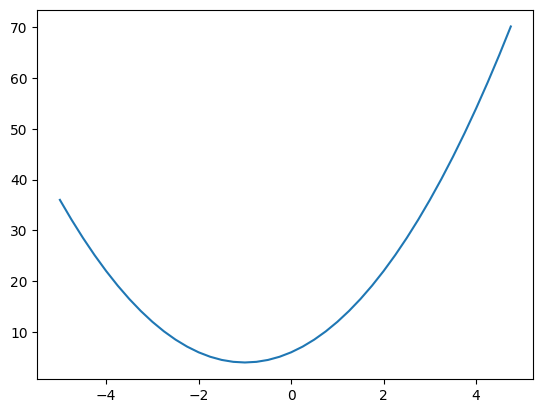

In [183]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)
plt.show()

In [359]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward 
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

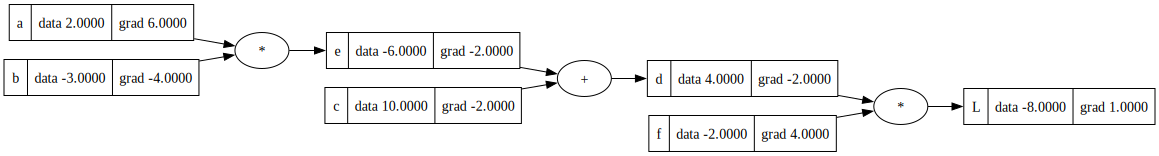

In [368]:
draw_dot(L)

In [367]:
e._backward()

NOTE: </br>
derivative of L by c and this is, tricky as c has not direct relation with L, but it is passed to d and that propagates to L.
dd/dc = ?  </br>
d = c+e    </br>
dd/dc = 1;dd/de = 1  </br>
dl/dd = ?   </br>
L = f*d  </br>
dl/dd = f  ; dl/df = d </br>

Now, what is dl/dc  </br>
Solution:
Chain Rule </br></br>
dz/dx = dz/dy * dy/dx </br></br>
So, multiply  derivative. </br>
Now, </br>
dl/dc = dl/dd * dd/dc = f * 1 = f is answer </br>
dl/de = dl/dd * dd/de = f*1 = f </br>
</br>
</br>
Now, Lets do for b and a</br>
e = b * a ; de/da = b ; de/db = a</br>
dl/db = dl/dd * dd/de * de/db =>  f * 1 * a</br>
dl / da = dl/dd * dd/de * de/da => f * 1 * b</br>
</br>
In our case </br>
a = Value(2.0, label='a') </br>
b = Value(-3.0, label='b') </br>
f = Value(-2.0, label='f') </br>
Now,  </br>
we found all the derivatives: </br>
dl/da = -2 * 1 * -3 = 6 </br>
dl/db = -2 * 1 * 2 = -4 </br>
dl/dc = -2 * 1 </br>
dl/de = -2 * 1 </br>
dl/dd = -2 </br>
dl/dl = 1 </br>
</br>
(dtanh(n))/dn = 1 - (tanh(n))**2

In [354]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = b+x1w1x2w2 ; n.label = 'n';
o = n.tanh(); o.label = 'o'

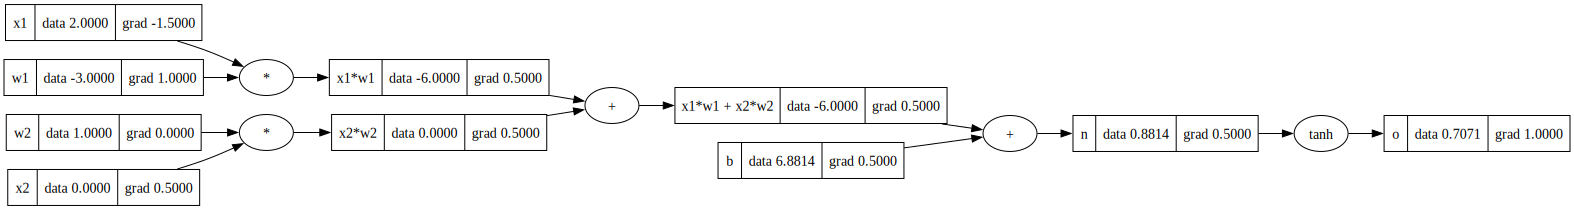

In [357]:
draw_dot(o)

In [356]:
o.backward() # Backprogation

Now Bug:
